# Fix Bad Quantity Values

The recipe1m+ dataset removes the "/" in many of the recipe quantities. Come up with a rule-based approach to correct these quantities. Check to see if the nutrients were impacted by this.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

We will have to retag all of the recipes if we end up needing to adjust the macros. Let's load in the recipes_with_servings_and_normalized_nutrients

In [28]:
df = pd.read_json('../../datasets/recipes_with_servings_and_normalized_nutrients.json', lines=True)
df.head()

,fsa_lights_per100g,id,ingredients,instructions,nutr_per_ingredient,nutr_values_per100g,partition,quantity,title,unit,...,status,found,error,n_servings,total_fat_per_serving,total_pro_per_serving,total_sod_per_serving,total_sat_per_serving,total_sug_per_serving,total_nrg_per_serving
0,"{'fat': 'orange', 'salt': 'green', 'saturates'...",0006ca31f4,"[{'text': 'cocoa, dry powder, unsweetened'}, {...",[{'text': 'Measure out the cocoa powder into a...,"[{'fat': 141.36, 'nrg': 2352.0, 'pro': 202.32,...","{'energy': 303.4353995519, 'fat': 5.0948469007...",train,"[{'text': '12'}, {'text': '12'}, {'text': '1'}]",Natural Peanut Butter Chocolate Bon Bons,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,200,True,NaN,12.0,22.740000,22.620000,35.333333,9.142667,282.130000,1354.333333
1,"{'fat': 'green', 'salt': 'red', 'saturates': '...",00073a6b36,"[{'text': 'cheese, pasteurized process, americ...","[{'text': 'Put milk, onion salt and pepper sau...","[{'fat': 54.0738363, 'nrg': 631.05987, 'pro': ...","{'energy': 57.1235315011, 'fat': 2.47764100560...",train,"[{'text': '6'}, {'text': '13'}, {'text': '14'}...",Easy Cheese Sauce,"[{'text': 'ounce'}, {'text': 'cup'}, {'text': ...",...,200,True,NaN,4.0,21.221703,34.425175,9195.832618,12.699995,42.204004,489.279367
2,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0007f5f800,"[{'text': 'cornmeal, degermed, unenriched, yel...","[{'text': 'In a large skillet, stir the cornme...","[{'fat': 2.75, 'nrg': 581.0, 'pro': 11.16, 'sa...","{'energy': 399.5182190719, 'fat': 18.337440469...",train,"[{'text': '1'}, {'text': '3/4'}, {'text': '3/4...",Cornmeal Crackers with Pumpkin Seeds,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,200,True,NaN,2.0,41.392187,16.085625,2352.156250,22.800094,6.873437,901.812500
3,"{'fat': 'green', 'salt': 'green', 'saturates':...",0008c6e39a,"[{'text': 'sugars, powdered'}, {'text': 'wheat...",[{'text': 'Move oven rack to lowest position.'...,"[{'fat': 0.0, 'nrg': 700.5, 'pro': 0.0, 'sat':...","{'energy': 149.4259987004, 'fat': 0.3679178142...",train,"[{'text': '1 1/2'}, {'text': '3/4'}, {'text': ...",Chocolate-Orange Angel Food Cake,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,200,True,NaN,1.0,5.945000,57.592500,1201.500000,2.045500,442.950000,2414.500000
4,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0009785a2e,"[{'text': 'rice, white, long-grain, regular, u...",[{'text': 'Add rice to a large pan of boiling ...,"[{'fat': 0.44, 'nrg': 205.0, 'pro': 4.25, 'sat...","{'energy': 57.3496659243, 'fat': 3.4322726627,...",test,"[{'text': '1'}, {'text': '3'}, {'text': '3'}, ...","Rice With Lemon, Capers & Parsley","[{'text': 'cup'}, {'text': 'cup'}, {'text': 't...",...,200,True,NaN,4.0,9.053906,2.161406,7085.093750,5.533250,0.194531,151.281250


In [29]:
df.keys()

Index(['fsa_lights_per100g', 'id', 'ingredients', 'instructions',
       'nutr_per_ingredient', 'nutr_values_per100g', 'partition', 'quantity',
       'title', 'unit', 'url', 'weight_per_ingr', 'total_fat', 'total_nrg',
       'total_pro', 'total_sat', 'total_sod', 'total_sug', 'yield_text',
       'servings_min', 'servings_max', 'serving_unit', 'confidence',
       'method_used', 'status', 'found', 'error', 'n_servings',
       'total_fat_per_serving', 'total_pro_per_serving',
       'total_sod_per_serving', 'total_sat_per_serving',
       'total_sug_per_serving', 'total_nrg_per_serving'],
      dtype='object')

In [30]:
# For some quantities the '/' character was removed, so 1/2 cup became 12 cup. We need to fix these.
# Let's look at all quantities that are greater than 10 for any unit that typically has fractions.
# quantity here is a list of quantities for each ingredient in the recipe and is represented as an
# array of objects in {"text": "12"} format. unit is also a list of units for each ingredient in the recipe
# and is represented as an array of objects in {"text": "cup"} format.
fractional_units = ['cup', 'cups', 'tbsp', 'tsp', 'lb', 'lbs', 'pounds', 'pound', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons']
common_large_fractional_quantities = ['12', '13', '14', '15', '16', '18', '19', '23', '25', '27', '29', '34', '35', '37', '38', '39', '45', '47', '49', '56', '57', '58', '59', '67', '78', '79', '89']

def correct_quantity(quantity_list, unit_list, nutr_per_ingredient):
    corrected_quantities = []
    adjusted_nutrients = []
    for qty_obj, unit_obj, nutr in zip(quantity_list, unit_list, nutr_per_ingredient):
        qty_text = qty_obj['text']
        unit_text = unit_obj['text']
        if unit_text in fractional_units and qty_text in common_large_fractional_quantities:
            # Insert a '/' before the last digit
            corrected_qty = qty_text[:-1] + '/' + qty_text[-1]
            corrected_quantities.append({'text': corrected_qty})
            # Adjust nutrients accordingly (assuming the original was meant to be a fraction)
            numerator, denominator = map(int, corrected_qty.split('/'))
            new_nutr = {}
            for k,v in nutr.items():
                # Convert the nutrient value to normalized unit
                new_nutr[k] = v / float(qty_text) * (numerator / denominator)
            adjusted_nutrients.append(new_nutr)
            # print(numerator, denominator)
            # print(f"Corrected quantity from {qty_text} to {corrected_qty} for unit {unit_text}")
        else:
            corrected_quantities.append(qty_obj)
            adjusted_nutrients.append(nutr)
    return corrected_quantities, adjusted_nutrients

In [31]:
r = df.iloc[0]
r['nutr_per_ingredient']

[{'fat': 141.36,
  'nrg': 2352.0,
  'pro': 202.32,
  'sat': 83.28,
  'sod': 216.0,
  'sug': 18.0},
 {'fat': 0.0,
  'nrg': 12372.0,
  'pro': 12.24,
  'sat': 0.0,
  'sod': 168.0,
  'sug': 3340.68},
 {'fat': 131.52,
  'nrg': 1528.0,
  'pro': 56.88,
  'sat': 26.432,
  'sod': 40.0,
  'sug': 26.88}]

In [32]:
r = df.iloc[0]
adj_quantity, adj_nutr =correct_quantity(r['quantity'], r['unit'], r['nutr_per_ingredient'])
print(adj_quantity)
print(adj_nutr)

[{'text': '1/2'}, {'text': '1/2'}, {'text': '1'}]
[{'fat': 5.890000000000001, 'nrg': 98.0, 'pro': 8.43, 'sat': 3.47, 'sod': 9.0, 'sug': 0.75}, {'fat': 0.0, 'nrg': 515.5, 'pro': 0.51, 'sat': 0.0, 'sod': 7.0, 'sug': 139.195}, {'fat': 131.52, 'nrg': 1528.0, 'pro': 56.88, 'sat': 26.432, 'sod': 40.0, 'sug': 26.88}]


In [33]:
# Loop through all recipes and correct quantities and nutrients and add new columns to the dataframe
corrected_quantities_list = []
adjusted_nutrients_list = []
for index, row in df.iterrows():
    adj_quantity, adj_nutr = correct_quantity(row['quantity'], row['unit'], row['nutr_per_ingredient'])
    corrected_quantities_list.append(adj_quantity)
    adjusted_nutrients_list.append(adj_nutr)
df['corrected_quantity'] = corrected_quantities_list
df['adjusted_nutrients'] = adjusted_nutrients_list

In [34]:
df.head()

,fsa_lights_per100g,id,ingredients,instructions,nutr_per_ingredient,nutr_values_per100g,partition,quantity,title,unit,...,error,n_servings,total_fat_per_serving,total_pro_per_serving,total_sod_per_serving,total_sat_per_serving,total_sug_per_serving,total_nrg_per_serving,corrected_quantity,adjusted_nutrients
0,"{'fat': 'orange', 'salt': 'green', 'saturates'...",0006ca31f4,"[{'text': 'cocoa, dry powder, unsweetened'}, {...",[{'text': 'Measure out the cocoa powder into a...,"[{'fat': 141.36, 'nrg': 2352.0, 'pro': 202.32,...","{'energy': 303.4353995519, 'fat': 5.0948469007...",train,"[{'text': '12'}, {'text': '12'}, {'text': '1'}]",Natural Peanut Butter Chocolate Bon Bons,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,12.0,22.740000,22.620000,35.333333,9.142667,282.130000,1354.333333,"[{'text': '1/2'}, {'text': '1/2'}, {'text': '1'}]","[{'fat': 5.890000000000001, 'nrg': 98.0, 'pro'..."
1,"{'fat': 'green', 'salt': 'red', 'saturates': '...",00073a6b36,"[{'text': 'cheese, pasteurized process, americ...","[{'text': 'Put milk, onion salt and pepper sau...","[{'fat': 54.0738363, 'nrg': 631.05987, 'pro': ...","{'energy': 57.1235315011, 'fat': 2.47764100560...",train,"[{'text': '6'}, {'text': '13'}, {'text': '14'}...",Easy Cheese Sauce,"[{'text': 'ounce'}, {'text': 'cup'}, {'text': ...",...,NaN,4.0,21.221703,34.425175,9195.832618,12.699995,42.204004,489.279367,"[{'text': '6'}, {'text': '1/3'}, {'text': '1/4...","[{'fat': 54.0738363, 'nrg': 631.05987, 'pro': ..."
2,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0007f5f800,"[{'text': 'cornmeal, degermed, unenriched, yel...","[{'text': 'In a large skillet, stir the cornme...","[{'fat': 2.75, 'nrg': 581.0, 'pro': 11.16, 'sa...","{'energy': 399.5182190719, 'fat': 18.337440469...",train,"[{'text': '1'}, {'text': '3/4'}, {'text': '3/4...",Cornmeal Crackers with Pumpkin Seeds,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,2.0,41.392187,16.085625,2352.156250,22.800094,6.873437,901.812500,"[{'text': '1'}, {'text': '3/4'}, {'text': '3/4...","[{'fat': 2.75, 'nrg': 581.0, 'pro': 11.16, 'sa..."
3,"{'fat': 'green', 'salt': 'green', 'saturates':...",0008c6e39a,"[{'text': 'sugars, powdered'}, {'text': 'wheat...",[{'text': 'Move oven rack to lowest position.'...,"[{'fat': 0.0, 'nrg': 700.5, 'pro': 0.0, 'sat':...","{'energy': 149.4259987004, 'fat': 0.3679178142...",train,"[{'text': '1 1/2'}, {'text': '3/4'}, {'text': ...",Chocolate-Orange Angel Food Cake,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,1.0,5.945000,57.592500,1201.500000,2.045500,442.950000,2414.500000,"[{'text': '1 1/2'}, {'text': '3/4'}, {'text': ...","[{'fat': 0.0, 'nrg': 700.5, 'pro': 0.0, 'sat':..."
4,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0009785a2e,"[{'text': 'rice, white, long-grain, regular, u...",[{'text': 'Add rice to a large pan of boiling ...,"[{'fat': 0.44, 'nrg': 205.0, 'pro': 4.25, 'sat...","{'energy': 57.3496659243, 'fat': 3.4322726627,...",test,"[{'text': '1'}, {'text': '3'}, {'text': '3'}, ...","Rice With Lemon, Capers & Parsley","[{'text': 'cup'}, {'text': 'cup'}, {'text': 't...",...,NaN,4.0,9.053906,2.161406,7085.093750,5.533250,0.194531,151.281250,"[{'text': '1'}, {'text': '3'}, {'text': '3'}, ...","[{'fat': 0.44, 'nrg': 205.0, 'pro': 4.25, 'sat..."


In [38]:
# Sum up adjusted nutrients to get total nutrients for the recipe and divide by the number of servings
totals = []
for index, row in df.iterrows():
    total_nutrients = {}
    n_servings = (row['servings_min'] + row['servings_max']) / 2
    for nutr in row['adjusted_nutrients']:
        for k,v in nutr.items():
            total_k = f"total_{k}_per_serving"
            if k in total_nutrients:
                total_nutrients[k] += v/max(n_servings,1)
            else:
                total_nutrients[k] = v/max(n_servings,1)
    totals.append(total_nutrients)
# Update the dataframe with the new total nutrients per serving
for k in totals[0].keys():
    df[f"total_{k}_per_serving"] = [total[k] for total in totals]

In [39]:
df.keys()

Index(['fsa_lights_per100g', 'id', 'ingredients', 'instructions',
       'nutr_per_ingredient', 'nutr_values_per100g', 'partition', 'quantity',
       'title', 'unit', 'url', 'weight_per_ingr', 'total_fat', 'total_nrg',
       'total_pro', 'total_sat', 'total_sod', 'total_sug', 'yield_text',
       'servings_min', 'servings_max', 'serving_unit', 'confidence',
       'method_used', 'status', 'found', 'error', 'n_servings',
       'total_fat_per_serving', 'total_pro_per_serving',
       'total_sod_per_serving', 'total_sat_per_serving',
       'total_sug_per_serving', 'total_nrg_per_serving', 'corrected_quantity',
       'adjusted_nutrients'],
      dtype='object')

In [40]:
df.head()

,fsa_lights_per100g,id,ingredients,instructions,nutr_per_ingredient,nutr_values_per100g,partition,quantity,title,unit,...,error,n_servings,total_fat_per_serving,total_pro_per_serving,total_sod_per_serving,total_sat_per_serving,total_sug_per_serving,total_nrg_per_serving,corrected_quantity,adjusted_nutrients
0,"{'fat': 'orange', 'salt': 'green', 'saturates'...",0006ca31f4,"[{'text': 'cocoa, dry powder, unsweetened'}, {...",[{'text': 'Measure out the cocoa powder into a...,"[{'fat': 141.36, 'nrg': 2352.0, 'pro': 202.32,...","{'energy': 303.4353995519, 'fat': 5.0948469007...",train,"[{'text': '12'}, {'text': '12'}, {'text': '1'}]",Natural Peanut Butter Chocolate Bon Bons,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,12.0,11.450833,5.485000,4.666667,2.491833,13.902083,178.458333,"[{'text': '1/2'}, {'text': '1/2'}, {'text': '1'}]","[{'fat': 5.890000000000001, 'nrg': 98.0, 'pro'..."
1,"{'fat': 'green', 'salt': 'red', 'saturates': '...",00073a6b36,"[{'text': 'cheese, pasteurized process, americ...","[{'text': 'Put milk, onion salt and pepper sau...","[{'fat': 54.0738363, 'nrg': 631.05987, 'pro': ...","{'energy': 57.1235315011, 'fat': 2.47764100560...",train,"[{'text': '6'}, {'text': '13'}, {'text': '14'}...",Easy Cheese Sauce,"[{'text': 'ounce'}, {'text': 'cup'}, {'text': ...",...,NaN,4.0,13.716703,8.395175,864.811784,7.807495,2.019004,166.279368,"[{'text': '6'}, {'text': '1/3'}, {'text': '1/4...","[{'fat': 54.0738363, 'nrg': 631.05987, 'pro': ..."
2,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0007f5f800,"[{'text': 'cornmeal, degermed, unenriched, yel...","[{'text': 'In a large skillet, stir the cornme...","[{'fat': 2.75, 'nrg': 581.0, 'pro': 11.16, 'sa...","{'energy': 399.5182190719, 'fat': 18.337440469...",train,"[{'text': '1'}, {'text': '3/4'}, {'text': '3/4...",Cornmeal Crackers with Pumpkin Seeds,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,2.0,41.392187,16.085625,2352.156250,22.800094,6.873438,901.812500,"[{'text': '1'}, {'text': '3/4'}, {'text': '3/4...","[{'fat': 2.75, 'nrg': 581.0, 'pro': 11.16, 'sa..."
3,"{'fat': 'green', 'salt': 'green', 'saturates':...",0008c6e39a,"[{'text': 'sugars, powdered'}, {'text': 'wheat...",[{'text': 'Move oven rack to lowest position.'...,"[{'fat': 0.0, 'nrg': 700.5, 'pro': 0.0, 'sat':...","{'energy': 149.4259987004, 'fat': 0.3679178142...",train,"[{'text': '1 1/2'}, {'text': '3/4'}, {'text': ...",Chocolate-Orange Angel Food Cake,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",...,NaN,1.0,5.945000,57.592500,1201.500000,2.045500,442.950000,2414.500000,"[{'text': '1 1/2'}, {'text': '3/4'}, {'text': ...","[{'fat': 0.0, 'nrg': 700.5, 'pro': 0.0, 'sat':..."
4,"{'fat': 'orange', 'salt': 'red', 'saturates': ...",0009785a2e,"[{'text': 'rice, white, long-grain, regular, u...",[{'text': 'Add rice to a large pan of boiling ...,"[{'fat': 0.44, 'nrg': 205.0, 'pro': 4.25, 'sat...","{'energy': 57.3496659243, 'fat': 3.4322726627,...",test,"[{'text': '1'}, {'text': '3'}, {'text': '3'}, ...","Rice With Lemon, Capers & Parsley","[{'text': 'cup'}, {'text': 'cup'}, {'text': 't...",...,NaN,4.0,8.813281,1.336406,400.718750,5.423250,0.160156,130.656250,"[{'text': '1'}, {'text': '3'}, {'text': '3'}, ...","[{'fat': 0.44, 'nrg': 205.0, 'pro': 4.25, 'sat..."


In [41]:
import seaborn as sns

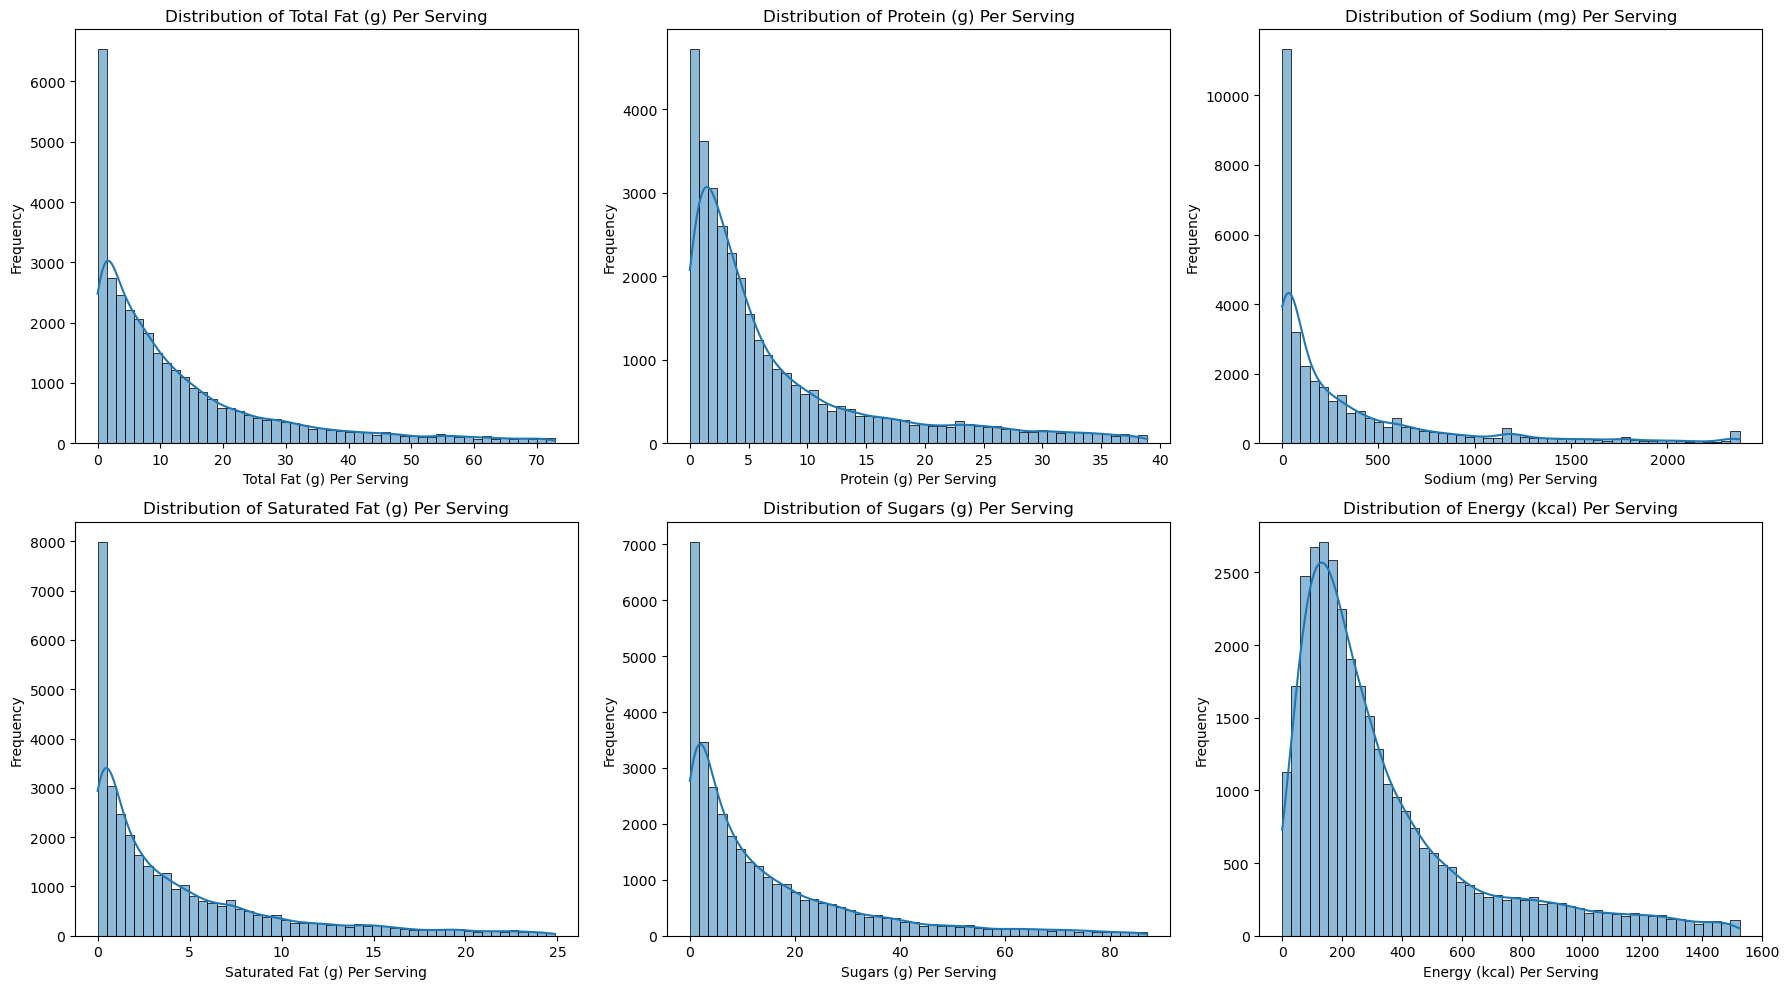

In [42]:
# Plot distribution of nutrients per serving
descriptions = {
    "total_fat_per_serving": "Total Fat (g)",
    "total_pro_per_serving": "Protein (g)",
    "total_sod_per_serving": "Sodium (mg)",
    "total_sat_per_serving": "Saturated Fat (g)",
    "total_sug_per_serving": "Sugars (g)",
    "total_nrg_per_serving": "Energy (kcal)"
}
cols = list(descriptions.keys())
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(cols):
    filtered_data = df[df[col] < df[col].quantile(0.90)]
    sns.histplot(filtered_data[col], bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {descriptions[col]} Per Serving')
    axes[i].set_xlabel(descriptions[col] + " Per Serving")
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [43]:
df.to_json("../../datasets/recipes_with_servings_and_normalized_nutrients_corrected_quantities.json", orient="records", lines=True)

In [ ]:
# Load in the llama3_1_vllm_async.jsonl file as a python dictionary
# Each line in the file is a separate JSON object
with open('../../datasets/.jsonl', 'r') as f:
    data = [json.loads(line) for line in f]
# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
# Display the first few rows of the DataFrame
df.head()

,id,title,cuisines,course,methods,diet_tags_llm,diet_flags,diet_violations,flavors,summary,...,instructions,search_text,search_card_full_md,servings_original,servings_final,macros_per_serving,servings_audit,tag_source_model,tag_timestamp,source_id
0,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,[global],dessert,[blend],[gluten-free],"{'vegetarian': True, 'vegan': False, 'pescatar...","{'vegetarian': [], 'vegan': ['peanut butter, s...","[chocolatey, peanut-buttery, sweet]",No-bake chocolate bonbons made with peanut but...,...,Measure out the cocoa powder into a mixing bow...,Natural Peanut Butter Chocolate Bon Bons. A gl...,# Natural Peanut Butter Chocolate Bon Bons\n\n...,12.0,12.0,"{'cal': 1354.3333333333, 'protein_g': 22.62, '...","{'servings_original': 12.0, 'servings_candidat...",meta-llama/Llama-3.1-8B-Instruct,2025-10-05T22:51:42.134704+00:00Z,0006ca31f4
1,0007f5f800,Cornmeal Crackers with Pumpkin Seeds,[global],snack,[],[gluten-free],"{'vegetarian': True, 'vegan': False, 'pescatar...","{'vegetarian': [], 'vegan': ['butter, without ...","[nutty, crunchy, savory, slightly sweet]",Homemade cornmeal crackers with toasted pumpki...,...,"In a large skillet, stir the cornmeal over mod...",Cornmeal Crackers with Pumpkin Seeds. A global...,# Cornmeal Crackers with Pumpkin Seeds\n\n*Sna...,2.0,2.0,"{'cal': 901.8125, 'protein_g': 16.085625, 'fat...","{'servings_original': 2.0, 'servings_candidate...",meta-llama/Llama-3.1-8B-Instruct,2025-10-05T22:51:42.143433+00:00Z,0007f5f800
2,0008c6e39a,Chocolate-Orange Angel Food Cake,[global],dessert,"[bake, freeze]",[],"{'vegetarian': True, 'vegan': False, 'pescatar...","{'vegetarian': [], 'vegan': ['egg, white, raw,...","[chocolatey, orangey, sweet]","Moist, fluffy angel food cake infused with coc...",...,Move oven rack to lowest position.\nHeat oven ...,Chocolate-Orange Angel Food Cake. A global des...,# Chocolate-Orange Angel Food Cake\n\n*Dessert...,1.0,1.0,"{'cal': 2414.5, 'protein_g': 57.5925, 'fat_g':...","{'servings_original': 1.0, 'servings_candidate...",meta-llama/Llama-3.1-8B-Instruct,2025-10-05T22:51:42.149413+00:00Z,0008c6e39a
3,0009785a2e,"Rice With Lemon, Capers & Parsley",[global],side,[boil],[low-fat],"{'vegetarian': True, 'vegan': False, 'pescatar...","{'vegetarian': [], 'vegan': ['butter, without ...","[lemony, herby, buttery]","Flavorful, aromatic side dish of cooked rice w...",...,Add rice to a large pan of boiling water.\nCoo...,"Rice With Lemon, Capers & Parsley. A global si...","# Rice With Lemon, Capers & Parsley\n\n*Side, ...",4.0,4.0,"{'cal': 151.28125, 'protein_g': 2.16140625, 'f...","{'servings_original': 4.0, 'servings_candidate...",meta-llama/Llama-3.1-8B-Instruct,2025-10-05T22:51:42.155447+00:00Z,0009785a2e
4,000c364a4a,Aunt Julie's Pineapple Cookies,[global],dessert,"[chill, bake]","[dairy-free, gluten-free, low-fat]","{'vegetarian': True, 'vegan': False, 'pescatar...","{'vegetarian': [], 'vegan': ['cheese, parmesan...","[sweet, tropical, buttery]",Classic pineapple cookies with a sweet and tan...,...,Mix the butter and the cream cheese in a large...,Aunt Julie's Pineapple Cookies. A global desse...,"# Aunt Julie's Pineapple Cookies\n\n*Dessert, ...",30.0,30.0,"{'cal': 309.6728606667, 'protein_g': 3.7191713...","{'servings_original': 30.0, 'servings_candidat...",meta-llama/Llama-3.1-8B-Instruct,2025-10-05T22:51:42.160590+00:00Z,000c364a4a


In [8]:
df.keys()

Index(['id', 'title', 'cuisines', 'course', 'methods', 'diet_tags_llm',
       'diet_flags', 'diet_violations', 'flavors', 'summary',
       'ingredients_raw', 'ingredients_norm', 'servings_avg', 'servings_min',
       'servings_max', 'serving_unit', 'quantities', 'units', 'instructions',
       'search_text', 'search_card_full_md', 'servings_original',
       'servings_final', 'macros_per_serving', 'servings_audit',
       'tag_source_model', 'tag_timestamp', 'source_id'],
      dtype='object')

In [70]:
# Fix the quantities of the llm tagged recipes
# Loop through all recipes and correct quantities and nutrients and add new columns to the dataframe
df = pd.read_json('../../VectorDB/recipes-vdb/data/llama3_1_vllm_async_corrected_quantities.jsonl',lines=True)


In [83]:
df.iloc[32979]['quantities']

[{'text': '1/2'},
 {'text': '3/4'},
 {'text': '3/4'},
 {'text': '3/4'},
 {'text': '1/3'},
 {'text': '3'},
 {'text': '3'},
 {'text': '2'},
 {'text': '2'},
 {'text': '1/2'}]

In [66]:
def correct_quantity_only(quantity_list, unit_list):
    corrected_quantities = []
    adjusted_nutrients = []
    for qty_obj, unit_obj in zip(quantity_list, unit_list):
        qty_text = qty_obj['text']
        unit_text = unit_obj['text']
        if unit_text in fractional_units and qty_text in common_large_fractional_quantities:
            # Insert a '/' before the last digit
            corrected_qty = qty_text[:-1] + '/' + qty_text[-1]
            corrected_quantities.append({'text': corrected_qty})
        else:
            corrected_quantities.append(qty_obj)
    return corrected_quantities

In [67]:
# Loop through all recipes and correct quantities and nutrients and add new columns to the dataframe
corrected_quantities_list = []
for index, row in df.iterrows():
    adj_quantity = correct_quantity_only(row['quantities'], row['units'])
    corrected_quantities_list.append(adj_quantity)
df['quantities'] = corrected_quantities_list

In [69]:
# Save to .jsonl file
df.to_json('../../VectorDB/recipes-vdb/data/llama3_1_vllm_async_corrected_quantities.jsonl', orient='records', lines=True)